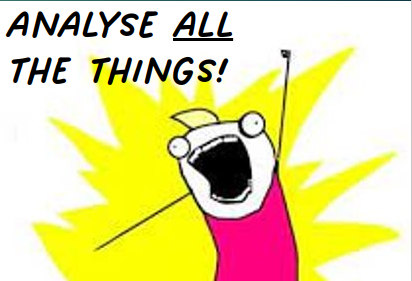
# RUN ALL THE THINGS 
### on Milton


This is a test interface between Jupyter Notebook and Milton. 
Requires: 

- ~~A working environment in your home area~~

- A little knowledge

- A litte luck

### Work in progress. Still to do:
 - Check files and folders exist or don't depending on settings
     


In [1]:
import os
import re
import sys
from read_roi import read_roi_zip #Need a kernel with this installed 

# First define your workflow settings


Microscopy address:
- /stornext/Img/data/prkfs1/m/Microscopy/

 GP Transfer
- /stornext/General/scratch/GP_Transfer/

 Your Home Area
- /home/users/allstaff/[your_user_name]/



In [23]:
config = {
    "input":"/path/to/cziImage/image.czi",
    "output":"/path/to/output",
    "roi_file":"/path/to/RoiZipFile/RoiSet.zip",    #or None
    "workflow_path":"/path/to/workflowfile/workflow.yml", #or None 
    "processing":"crop",
    "deconvolution": "CUDA_GPU",                           
    "deconvolution_num_iter":20,
    "deconvolution_psf":["/path/to/psfs/488.tif",
                         "/path/to/psfs/561.tif",
                         "/path/to/psfs/640.tif",
                         "/path/to/psfs/640.tif"],
    "time_range":[1,11], #Change to None to do all
    "channel_range":[0,2], #ditto    
    "output_file_type":"h5"
}

# Next Decide on your Milton Settings 

In [4]:
milton_config = {
    'job-name':'jupyter_submission_test',
    #how long does one "job" take
    #Note that job will fail if it goes over this time
    "time":"1:00:00",  #hours:minutes:secounds
    #logFile output
    "logfiles_path":"/path/to/put/output_logs/", #make sure this exists
    #cpus per task
    "cpus-per-task":12,
    #GB memory required
    "mem":64,
    #email 
    "email_address":"whitehead@wehi.edu.au",
    "use_gpu_nodes":True,
    #This is a shared and tested environment - but you can change if you have a local one
    "conda_env_name":"/stornext/Img/data/prkfs1/m/Microscopy/BAC_Conda_envs/napari_milton/",
}


#### If you're using roi_file, this is handy:

In [5]:
def get_rois(config_settings):
    if "roi_file" in config_settings.keys() and "roi_file" != None:    
        roi_file_path = config_settings["roi_file"]
        if os.path.exists(roi_file_path):
            print("Found roi file")
            rois = read_roi_zip(roi_file_path)
            nrois = len(list(rois.keys()))
            print("There are %i rois" % nrois)
            return nrois
        else:
            print("Roi file defined but not found")
            return False
    else:
        print("No roi file found")
        return False    
    

#### This function makes a config file to send to napari_lattice --config 

In [6]:
def write_config_file(config_settings,output_file_location):
    with open(output_file_location,'w') as f:
        for key,val in config_settings.items():    
            if val is not None:
                if type(val) is str:
                    print('%s: "%s"' % (key,val),file=f)

                if type(val) is int:
                    print('%s: %i' % (key,val),file=f)

                if type(val) is list:
                    print("%s:" % key,file=f)
                    for x in val:
                        if type(x) is int:
                            print(" - %i" % x,file=f)
                        else:
                            print(' - "%s"' % x,file=f)
            
    print("Config found written to %s" % output_file_location)
                            

### This one prepares the milton submission script

In [7]:
def write_submission_sh(milton_config_settings,
                        config_yml_location,
                        parallelisation_keyword,
                        n_jobs,
                        output_file_location):
    
    with open(output_file_location,'w') as f:

        print("#!/bin/bash",file=f)
        print("#SBATCH --job-name=%s" % milton_config_settings['job-name'],file=f)
        print("#SBATCH --time=%s" % milton_config_settings['time'],file=f)
        print("#SBATCH --ntasks=1",file=f)
        print("#SBATCH --output=%s%s_%%A_%%a.out" % 
              (milton_config_settings['logfiles_path'],milton_config_settings['job-name']),file=f)
        print("#SBATCH --cpus-per-task=%i" % milton_config_settings['cpus-per-task'],file=f)
        print("#SBATCH --mem=%iG" % milton_config_settings['mem'],file=f)
        print("#SBATCH --mail-type=END",file=f)
        print("#SBATCH --mail-use=%s" % milton_config_settings['email_address'],file=f)
        if(milton_config_settings['use_gpu_nodes']):
            print("#SBATCH --partition=gpuq",file=f)
            print("#SBATCH --gres=gpu:A30:1",file=f)
        print("#SBATCH --array=0-%i" % (n_jobs-1),file=f)


        print("",file=f)
        print("source /stornext/System/data/apps/anaconda3/anaconda3-2019.03/etc/profile.d/conda.sh",file=f)
        print("conda activate %s" % milton_config_settings['conda_env_name'],file=f)
        print("",file=f)

        print("export TMPDIR=/vast/scratch/users/$USER/tmp",file=f)
        print("mkdir -p $TMPDIR",file=f)

        print("",file=f)

        print("xvfb-run -a napari_lattice --config %s --%s $SLURM_ARRAY_TASK_ID" % 
              (config_yml_location,parallelisation_keyword), file=f)

#write_submission_sh(milton_config,'/path/to/config.yml','roi_number',4,'asdf/test.sh')    


### Where are you going to put the settings files

In [8]:
config_file = 'test/configtest.yml'
submission_file = 'test/submission_test.sh'

#### Make the config file

In [24]:

write_config_file(config,config_file)


Config found written to test/configtest.yml


#### Currently parallelising over roi_number - but can be changed

In [18]:
n_rois = get_rois(config)

write_submission_sh(milton_config,
                    config_file,
                    'roi_number',
                    n_rois,
                    submission_file)

Found roi file


# SUBMIT TO MILTON!

In [27]:
!sbatch $submission_file

Submitted batch job 9431057


In [ ]:
!squeue -u [username]

### Things that might cause failures

 - forgot Xvfb import 
 - Image files / roi files / workflow files don't exists where you've specified
 - Output files already exist
 - Something I've overlooked
 - Something I haven't overlooked, but neglected to fix